# Intel Crypto Guide Task 2: Data Collection and Preparation

Instructions:
- Create the dataset
- Conduct feature analysis
- Format the data
- Conduct data quality analysis


In [13]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import json
import websocket
import os
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.model_selection import train_test_split

In [2]:
assets = ["BTC", "ETH", "LTC"]
assets_hourly = [coins.lower() + "usdt@ticker_1h" for coins in assets]
assets_hourly = "/".join(assets_hourly)
print(assets_hourly)

assets_daily = [coins.lower() + "usdt@ticker_1d" for coins in assets]
assets_daily = "/".join(assets_daily)
print(assets_daily)


btcusdt@ticker_1h/ethusdt@ticker_1h/ltcusdt@ticker_1h
btcusdt@ticker_1d/ethusdt@ticker_1d/ltcusdt@ticker_1d


In [ ]:
csv_dir_hourly = "content/Dataset/hourlyV2"
csv_dir_daily = "content/Dataset/daily24thV2"
os.makedirs(csv_dir_daily)
os.makedirs(csv_dir_hourly)

In [4]:
csv_files_name = ["Bitcoin.csv", "Ethereum.csv", "Litecoin.csv"]

csv_files_hourly = [os.path.join(csv_dir_hourly, coins) for coins in csv_files_name]
print(csv_files_hourly)

csv_files_daily = [os.path.join(csv_dir_daily, coins) for coins in csv_files_name]
print(csv_files_daily)

['content/Dataset/hourly/Bitcoin.csv', 'content/Dataset/hourly/Ethereum.csv', 'content/Dataset/hourly/Litecoin.csv']
['content/Dataset/daily24th/Bitcoin.csv', 'content/Dataset/daily24th/Ethereum.csv', 'content/Dataset/daily24th/Litecoin.csv']


In [ ]:
for file in csv_files_hourly:
    os.makedirs(os.path.dirname(file), exist_ok=True)
    if not os.path.exists(file):
        with open(file, "w") as f:
            f.write("Date,Open,High,Low,Close,Volume\n")
            f.close()
    else:
        print(f"{file} already exists.")

for file in csv_files_daily:
    os.makedirs(os.path.dirname(file), exist_ok=True)
    if not os.path.exists(file):
        with open(file, "w") as f:
            f.write("Date,Open,High,Low,Close,Volume\n")
            f.close()
    else:
        print(f"{file} already exists.")

In [6]:
source = ""

In [7]:
def retrieve_csv_file(symbol: str, hourly=True):
    # print(symbol == "btcusdt")
    if hourly:
        csv_file_in_use = csv_files_hourly
    else:
        csv_file_in_use = csv_files_daily

    if symbol:
        if symbol ==  "btcusdt":
            return csv_file_in_use[0]
        elif symbol ==  "ethusdt":
            return csv_file_in_use[1]
        elif symbol ==  "ltcusdt":
            return csv_file_in_use[2]

    else:
        raise ValueError("Invalid symbol")

In [ ]:
def on_open(ws):
    print("Connection opened")

def on_message(ws, message, hourly=True):
    message = json.loads(message)
    global source
    source = message
    # print(message)

    coin_data = message['data']

    symbol = coin_data["s"].lower()
    csv_save_file = retrieve_csv_file(str(symbol), hourly)
    timestamp = coin_data["E"]
    open_price = coin_data["o"]
    high_price = coin_data["h"]
    low_price = coin_data["l"]
    close_price = coin_data["c"]
    volume = coin_data["v"]

    timestamp = pd.to_datetime(timestamp)

    df = pd.DataFrame({
        "timestamp": [timestamp],
        "open": [open_price],
        "high": [high_price],
        "low": [low_price],
        "close": [close_price],
        "volume": [volume]
    })

    df.to_csv(f"{csv_save_file}", mode="a", header=False, index=False)


def on_close(ws, close_status_code, close_msg):
    print("Connection closed")

def on_error(ws, error):
    print("Error:", error)

In [9]:
socket_hourly = f"wss://stream.binance.com:9443/stream?streams={assets_hourly}"
socket_daily = f"wss://stream.binance.com:9443/stream?streams={assets_daily}"
socket_hourly, socket_daily

('wss://stream.binance.com:9443/stream?streams=btcusdt@ticker_1h/ethusdt@ticker_1h/ltcusdt@ticker_1h',
 'wss://stream.binance.com:9443/stream?streams=btcusdt@ticker_1d/ethusdt@ticker_1d/ltcusdt@ticker_1d')

In [11]:
def run_websocket_hourly(socket_name):
    ws = websocket.create_connection(socket_name)
    # print("WebSocket connection opened")

    # ws = websocket.WebSocketApp(
    #     socket_hourly,
    #     on_open=on_open,
    #     on_close=on_close,
    #     on_error=on_error,
    #     on_message=on_message
    # )

    result = ws.recv()
    on_message(ws, result)

    print("Received:", result)
    ws.close()

def run_websocket_daily(socket_name):
    ws = websocket.create_connection(socket_name)
    # print("WebSocket connection opened")

    # ws = websocket.WebSocketApp(
    #     socket_daily,
    #     on_open=on_open,
    #     on_close=on_close,
    #     on_error=on_error,
    #     on_message=on_message
    # )

    result = ws.recv()
    on_message(ws, result, hourly=False)
    print("Received:", result)
    ws.close()


In [ ]:
# Running this cell will start requesting cryptocurrency OHLCV data from Binance servers
count = 0
socket = "wss://stream.binance.com:9443/stream?streams="
while True:
    if count % 24 == 0:
        print("\n\nDaily report:")
        # runs the websocket for daily data
        for coins in assets:
            socket_name = socket + coins.lower() + "usdt@ticker_1d"
            run_websocket_daily(socket_name)

    count += 1
    print("\n\nHourly report:")
    for coins in assets:
        socket_name = socket + coins.lower() + "usdt@ticker_1h"
        run_websocket_hourly(socket_name)

    time.sleep(3600)

I had kept the above cell block running for a few days and have collected data.<br>
I have additionally also downloaded the past 10 years price history of each of the desired cryptocurrency through https://in.investing.com/ site
<br>

## EDA

In [78]:
df_litecoin = pd.read_csv('/content/Litecoin Historical Data.csv')
df_litecoin.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,05-04-2025,83.76,84.40,84.94,83.58,910.01K,-0.76%
1,04-04-2025,84.41,83.43,85.09,81.64,933.59K,1.19%
2,03-04-2025,83.41,81.53,84.65,80.18,962.77K,2.30%
3,02-04-2025,81.54,84.48,88.49,81.02,1.44M,-3.49%
4,01-04-2025,84.48,82.95,85.88,82.89,739.37K,1.84%


In [79]:
df_litecoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3147 non-null   object 
 1   Close     3147 non-null   float64
 2   Open      3147 non-null   float64
 3   High      3147 non-null   float64
 4   Low       3147 non-null   float64
 5   Vol.      3147 non-null   object 
 6   Change %  3147 non-null   object 
dtypes: float64(4), object(3)
memory usage: 172.2+ KB


In [80]:
df_litecoin.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [81]:
def convert_vol_int(obj):
    if isinstance(obj, str):
        if obj.endswith("K"):
            return float(obj[:-1]) / 1000
        elif obj.endswith("M"):
            return float(obj[:-1])
        else:
            return float(obj)
    return obj

def convert_change_int(obj):
    if isinstance(obj, str) and obj.endswith("%"):
        return float(obj[:-1])
    return obj

In [82]:
df_litecoin["Vol."] = df_litecoin['Vol.'].apply(convert_vol_int)
df_litecoin['Change %'] = df_litecoin['Change %'].apply(convert_change_int)
df_litecoin['Date'] = pd.to_datetime(df_litecoin['Date'], format='%d-%M-%Y').dt.date

In [83]:
df_litecoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3147 non-null   object 
 1   Close     3147 non-null   float64
 2   Open      3147 non-null   float64
 3   High      3147 non-null   float64
 4   Low       3147 non-null   float64
 5   Vol.      3147 non-null   float64
 6   Change %  3147 non-null   float64
dtypes: float64(6), object(1)
memory usage: 172.2+ KB


In [84]:
df_litecoin.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,2025-01-05,83.76,84.40,84.94,83.58,0.91001,-0.76
1,2025-01-04,84.41,83.43,85.09,81.64,0.93359,1.19
2,2025-01-03,83.41,81.53,84.65,80.18,0.96277,2.30
3,2025-01-02,81.54,84.48,88.49,81.02,1.44000,-3.49
4,2025-01-01,84.48,82.95,85.88,82.89,0.73937,1.84


In [85]:
df_litecoin.columns = ['Date','Close', 'Open', 'High', 'Low', 'Volume', 'Change']

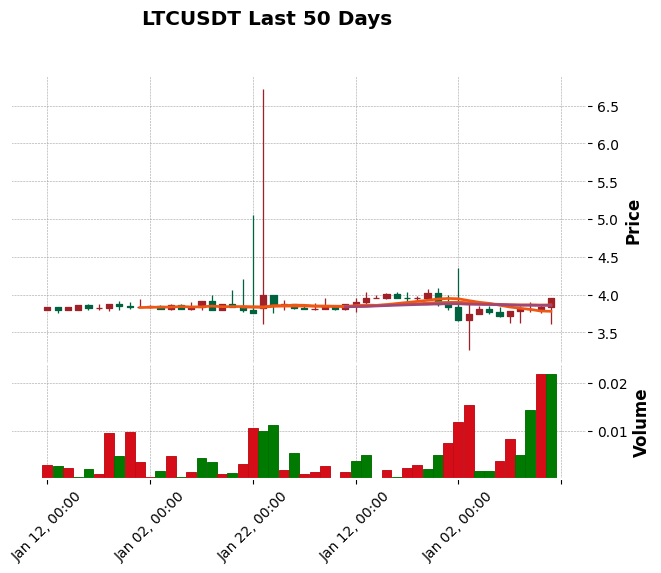

In [86]:
import pandas as pd
import mplfinance as mpf

df_litecoin['Date'] = pd.to_datetime(df_litecoin['Date'])
df_litecoin.set_index('Date', inplace=True)

mpf.plot(df_litecoin.tail(50),
         type='candle',
         style='charles',
         volume=True,
         title='LTCUSDT Last 50 Days',
         mav=(10, 20, 30))


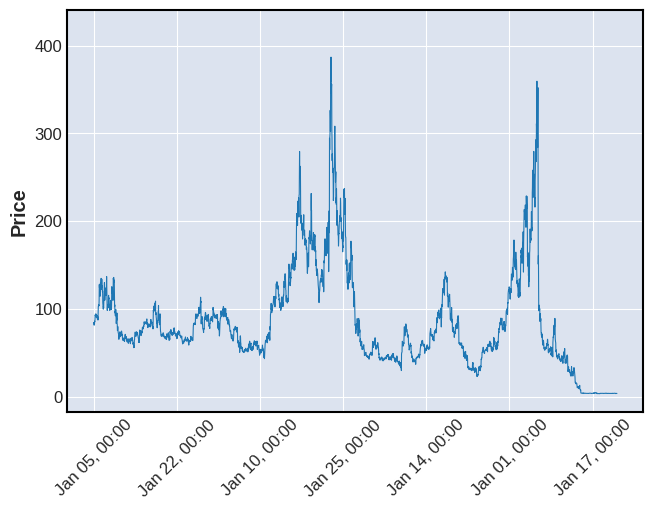

In [87]:
mpf.plot(df_litecoin, type='line')

In [88]:
df_litecoin.isnull().sum()

,0
Close,0
Open,0
High,0
Low,0
Volume,0
Change,0


In [89]:
df_litecoin.duplicated().sum()

np.int64(0)

In [90]:
df_litecoin.reset_index(inplace=True)

In [91]:
print(df_litecoin['Date'].dtype)

datetime64[ns]


<Axes: >

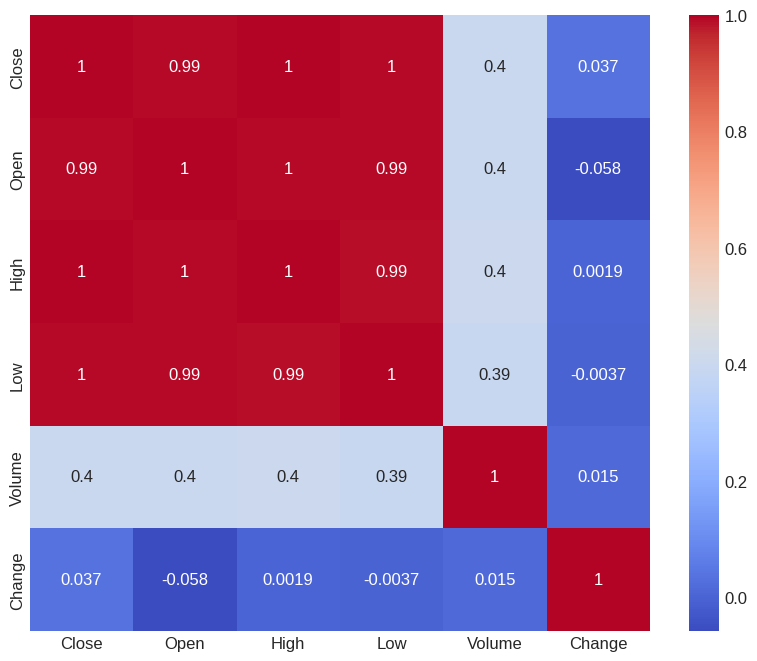

In [92]:
corr = df_litecoin.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')

In [93]:
np.triu(np.ones(corr.shape), k=1)

array([[0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.]])

In [94]:
threshold = 0.9
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]
to_drop

['Open', 'High', 'Low']

I am dropping ['Open', 'High', 'Low'] as they are highly correlated to Close column.

In [102]:
X = df_litecoin
y = df_litecoin['Close'].shift(-1)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [104]:
X_train

,Date,Close,Open,High,Low,Volume,Change
0,2025-01-05,83.76,84.40,84.94,83.58,0.91001,-0.76
1,2025-01-04,84.41,83.43,85.09,81.64,0.93359,1.19
2,2025-01-03,83.41,81.53,84.65,80.18,0.96277,2.30
3,2025-01-02,81.54,84.48,88.49,81.02,1.44000,-3.49
4,2025-01-01,84.48,82.95,85.88,82.89,0.73937,1.84
...,...,...,...,...,...,...,...
2512,2018-01-20,139.79,135.16,140.57,132.77,0.89222,3.42
2513,2018-01-19,135.16,136.07,137.66,133.07,0.88565,-0.66
2514,2018-01-18,136.06,132.65,137.51,129.18,1.17000,2.59
2515,2018-01-17,132.63,139.26,141.44,131.64,1.02000,-4.76


In [107]:
y_train

,Close
0,84.41
1,83.41
2,81.54
3,84.48
4,82.96
...,...
2512,135.16
2513,136.06
2514,132.63
2515,139.26
